In [68]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [69]:
import numpy as np
import pandas as pd

In [70]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [71]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect



In [72]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [73]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [74]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [75]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [76]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Precipitation Analysis

In [104]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).all()
print(last_date)

[('2017-08-23',)]


Text(0.5, 1.0, 'Honolulu Precipitation, 8/23/2016 - 8/23/2017')

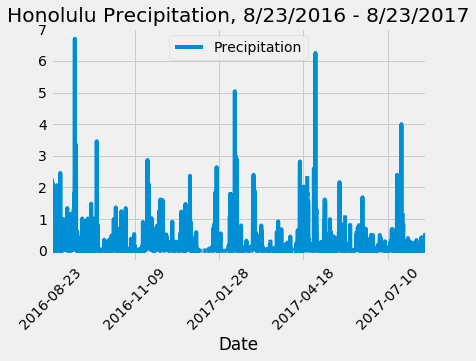

In [48]:
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

precip_data=session.query(Measurement.date, Measurement.prcp).\
    filter((Measurement.date >= '2016-08-23')).\
    order_by(Measurement.date).all()

df = pd.DataFrame(precip_data, columns=["Date", "Precipitation"])
df.set_index('Date', inplace=True)
df.plot()
plt.xticks(rotation=45)
plt.title("Honolulu Precipitation, 8/23/2016 - 8/23/2017")


In [49]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [50]:
# Design a query to show how many stations are available in this dataset?
station_data = session.query(Station.name).count()
print(f"There are {station_data} stations in the data set")


There are 9 stations in the data set


In [51]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#sel = [Measurement.station, func.count(Measurement.date)]
station_count = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date)).all()
station_count


[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [52]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281')).all()
print(f"Lowest temperature, Highest Temperature, Average Temperature")
active_station_temp

Lowest temperature, Highest Temperature, Average Temperature


[(53.0, 87.0, 71.66378066378067)]

Text(0.5, 1.0, 'Station USC00519281 Temperature Frequency')

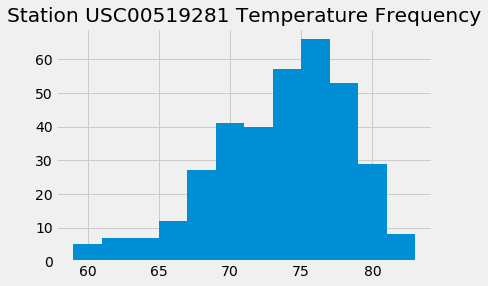

In [53]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()

df2 = pd.DataFrame(station_data, columns=["Date", "Temperature"])
df2.set_index('Date', inplace=True)

x = df2.Temperature
plt.hist(x, bins=12)
plt.title('Station USC00519281 Temperature Frequency')

![precipitation](Images/station-histogram.png)

In [54]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [55]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

## For this excercise, defining "trip" as Sept 1, 2016 through Sept 15, 2016
trip_temps = calc_temps('2016-09-01', '2016-09-15')
trip_temps_df = pd.DataFrame(trip_temps, columns = ['tmin', 'tavg', 'tmax'])
trip_temps_df.head()

,tmin,tavg,tmax
0,71.0,77.580645,84.0


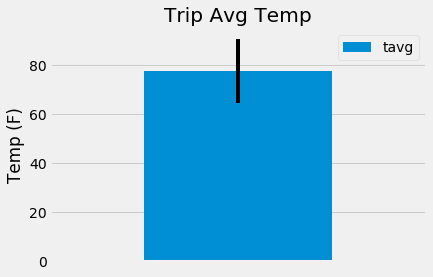

In [66]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temps_df.plot.bar(y='tavg', yerr=(trip_temps_df['tmax'] - trip_temps_df['tmin']), title='Trip Avg Temp')
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.show()



## Optional Challenge Assignment

In [57]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [58]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [59]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [60]:
# Plot the daily normals as an area plot with `stacked=False`
